# Introduction to `pypsa`

<img src="pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `pyomo`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `pyomo` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
|  | **not used in this course** | 
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with extendable energy capacity. |
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |


:::{note}
Links in the table lead to documentation for each component.
:::


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

## Simple electricity market example

Let's get acquainted with PyPSA to build a variant of one of the simple electricity market models we previously built in `pyomo`. Hopefully, it can convince you that it will be easier to work with PyPSA than with `pyomo`.

We have the following data:

- fuel costs in € / MWh$_{th}$ 

In [411]:
fuel_cost = dict(
    coal=8, 
    gas=100, 
    oil=48,
)

- efficiencies of thermal power plants in MWh$_{el}$ / MWh$_{th}$

In [412]:
efficiency = dict(
    coal=0.33,
    gas=0.58,
    oil=0.35,
)

- specific emissions in t$_{CO_2}$ / MWh$_{th}$

In [413]:
# t/MWh thermal
emissions = dict(
    coal=0.34, 
    gas=0.2, 
    oil=0.26,
    hydro=0,
)

- power plant capacities in MW

In [414]:
power_plants = {
    "SA": {"coal": 35000, "wind": 3000, "gas": 8000, "oil": 2000},
    "MZ": {"hydro": 1200},
}

- electrical load in MW

In [415]:
loads = {
    "SA": 42000,
    "MZ": 650,
}

## Building a basic network

By convention, PyPSA is imported without an alias:

In [416]:
import pypsa

First, we create a new network object which serves as the overall container for all components.

In [417]:
n = pypsa.Network()

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [418]:
n.add("Bus", "SA", y=-30.5, x=25, v_nom=400, carrier='AC')
n.add("Bus", "MZ", y=-18.5, x=35.5, v_nom=400, carrier='AC')

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [419]:
n.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
SA,400.0,,25.0,-30.5,AC,None,1.0,0.0,inf,PQ,
MZ,400.0,,35.5,-18.5,AC,None,1.0,0.0,inf,PQ,


You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components. 

There's a variant of `n.add()` called `n.madd()` which allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting.

The function `n.madd()` again takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

In [420]:
emissions

{'coal': 0.34, 'gas': 0.2, 'oil': 0.26, 'hydro': 0}

In [421]:
n.madd(
    "Carrier",
    ["coal", "gas", "oil", "hydro", "wind"], 
    co2_emissions=emissions,
    nice_name=["Coal", "Gas", "Oil", "Hydro", "Onshore Wind"],
    color=["grey", "indianred", "black", "aquamarine", "dodgerblue"],
)

Index(['coal', 'gas', 'oil', 'hydro', 'wind'], dtype='object')

The `n.add()` function is very general. It lets you add any component to the network object `n`. For instance, in the next step we add **generators** for all the different power plants.

In Mozambique:

In [422]:
n.add("Generator",
    "MZ hydro",
    bus="MZ",
    carrier='hydro',
    p_nom=1200, # MW
    marginal_cost=0, # default
)

In South Africa (in a loop):

In [423]:
for tech, p_nom in power_plants["SA"].items():
    n.add("Generator",
        f"SA {tech}",
        bus="SA",
        carrier=tech,
        efficiency=efficiency.get(tech, 1),
        p_nom=p_nom,
        marginal_cost=fuel_cost.get(tech, 0) / efficiency.get(tech, 1),
    )

As a result, the `n.generators` DataFrame looks like this:

In [424]:
n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
MZ hydro,MZ,PQ,,1200.0,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
SA coal,SA,PQ,,35000.0,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
SA wind,SA,PQ,,3000.0,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
SA gas,SA,PQ,,8000.0,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
SA oil,SA,PQ,,2000.0,False,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [425]:
n.add("Load",
    "SA electricity demand",
    bus="SA",
    p_set=loads["SA"],
    carrier='electricity',
)

In [426]:
n.add("Load",
    "MZ electricity demand",
    bus="MZ",
    p_set=loads["MZ"],
    carrier='electricity',
)

In [427]:
n.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
SA electricity demand,SA,electricity,,42000.0,0.0,-1.0
MZ electricity demand,MZ,electricity,,650.0,0.0,-1.0


Finally, we add the connection between Mozambique and South Africa with a 500 MW line:

In [428]:
n.add("Line",
    "SA-MZ",
    bus0="SA",
    bus1="MZ",
    s_nom=500,
    x=1,
)

In [429]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
SA-MZ,SA,MZ,,1.0,0.0,0.0,0.0,500.0,False,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can have a sneak peek at the network we built with the `n.plot()` function. More details on this in a bit.

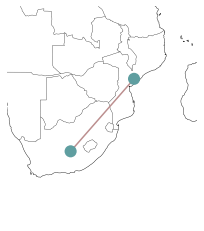

In [430]:
n.plot(bus_sizes=1, margin=1);

## Optimisation

With all input data transferred into PyPSA's data structure, we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.lopf()`. **LOPF** stands for *Linear Optimal Power Flow*, which hints at the linearisation of power flows in our search for cost-optimal dispatch descisions.

The `n.lopf()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver. We already know the different solvers from the introduction to `pyomo` (e.g. "cbc", "glpk", "gurobi" etc.). They need to be installed on your computer, to use them here!

In [431]:
n.lopf(solver_name='cbc')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.09s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.38e+06


('ok', 'optimal')

Let's have a look at the results.

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different location than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [432]:
n.generators_t.p

Generator,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,1150,35000,3000,1500,2000


or if you prefer it in relation to the generators nominal capacity

In [433]:
n.generators_t.p / n.generators.p_nom

Generator,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.958333,1.0,1.0,0.1875,1.0


You see that the time index has the value 'now'. This is the default index when no time series data has been specified and the network only covers a single state (e.g. a particular hour). 

Similarly you will find the power flow in transmission lines at

In [434]:
n.lines_t.p0

Line,SA-MZ
snapshot,
now,-500


In [435]:
n.lines_t.p1

Line,SA-MZ
snapshot,
now,500


The `p0` will tell you the flow from `bus0` to `bus1`. `p1` will tell you the flow from `bus1` to `bus0`.

What about the shadow prices?

In [436]:
n.buses_t.marginal_price

Bus,SA,MZ
snapshot,,
now,172.41379,0.0


## Basic network plotting

For plotting PyPSA network, we're going to need the help of some old friends:

In [437]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

PyPSA has a built-in plotting function based on `matplotlib`, ....

(<matplotlib.collections.PatchCollection at 0x7f1781b62f10>,
 <matplotlib.collections.LineCollection at 0x7f1781e1cc40>)

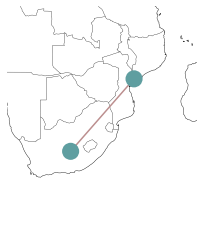

In [438]:
n.plot(margin=1, bus_sizes=2)

Since we have provided `x` and `y` coordinates for our buses, `n.plot()` will try to plot the network on a map by default. Of course, there's an option to deactivate this behaviour:

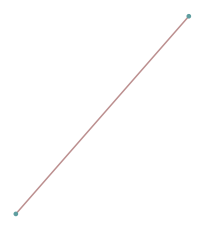

In [439]:
n.plot(geomap=False);

The `n.plot()` function has a variety of styling arguments to tweak the appearance of the buses, the lines and the map in the background:

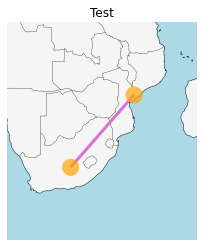

In [440]:
n.plot(
    margin=1,
    bus_sizes=2,
    bus_colors='orange',
    bus_alpha=0.7,
    color_geomap=True,
    line_colors='orchid',
    line_widths=3,
    title='Test',

);

Just like with `geopandas` we can also control the projection of the network plot:

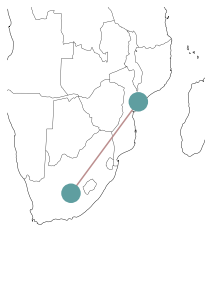

In [441]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.EqualEarth())

n.plot(ax=ax, margin=1, bus_sizes=2);

We can use the `bus_sizes` argument of `n.plot()` to display the regional distribution of load. First, we calculate the total load per bus:

In [442]:
s = n.loads.groupby('bus').p_set.sum() / 1e4

In [443]:
s

bus
MZ    0.065
SA    4.200
Name: p_set, dtype: float64

The resulting `pandas.Series` we can pass to `n.plot(bus_sizes=...)`:

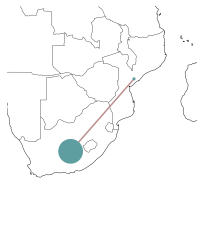

In [444]:
n.plot(margin=1, bus_sizes=s);

The important point here is, that `s` needs to have entries for all buses, i.e. its index needs to match `n.buses.index`.

The `bus_sizes` argument of `n.plot()` can be even more powerful. It can produce pie charts, e.g. for the mix of electricity generation at each bus.

The dispatch of each generator, we can find at:

In [445]:
n.generators_t.p.loc["now"]

Generator
MZ hydro     1150
SA coal     35000
SA wind      3000
SA gas       1500
SA oil       2000
Name: now, dtype: int64

If we group this by the **bus** and **carrier**...

In [446]:
s = n.generators_t.p.loc["now"].groupby(
    [n.generators.bus, n.generators.carrier]
).sum()

... we get a multi-indexed `pandas.Series` ...

In [447]:
s

bus  carrier
MZ   hydro       1150
SA   coal       35000
     gas         1500
     oil         2000
     wind        3000
Name: now, dtype: int64

... which we can pass to `n.plot(bus_sizes=...)`:

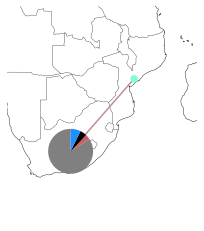

In [448]:
n.plot(margin=1, bus_sizes=s/3000);

How does this magic work? The plotting function will look up the colors specified in `n.carriers` for each carrier and match it with the second index-level of `s`.

## Modifying networks

Modifying data of components in an existing PyPSA network is as easy as modifying the entries of a `pandas.DataFrame`. For instance, if we want to reduce the cross-border transmission capacity between South Africa and Mozambique, we'd run:

In [451]:
n.lines.loc["SA-MZ", "s_nom"] = 400

In [452]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom
name,,,,,,,,,,,,,,,,,,,,,
SA-MZ,SA,MZ,,1.0,0.0,0.0,0.0,400.0,False,0.0,...,inf,0,0.000006,0.0,0.0,0.0,0.000006,0.0,500.0,400.0


In [453]:
n.lopf()

You can see that the production of the hydro power plant was reduced and that of the gas power plant increased owing to the reduced transmission capacity.

In [454]:
n.generators_t.p

## Global constraints for emission limits

In the example above, we happen to have some spare gas capacity with lower carbon intensity than the coal and oil generators. We could use this to lower the emissions of the system, but it will be more expensive. We can implement the limit of carbon dioxide emissions as a constraint.

This is achieved in PyPSA through **Global Constraints** which apply to many components at once.

But first, we need to calculate the current level of emissions to set a sensible limit.

We can compute the emissions per generator (in tonnes of CO$_2$) in the following way.

$$\frac{g_{i,s,t} \cdot \rho_{i,s}}{\eta_{i,s}}$$

where $ \rho$ is the specific emissions (tonnes/MWh thermal) and $\eta$ is the conversion efficiency (MWh electric / MWh thermal) of the generator with dispatch $g$ (MWh electric):

In [456]:
e = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)
e

,MZ hydro,SA coal,SA wind,SA gas,SA oil
snapshot,,,,,
now,0.0,36060.606061,NaN,551.724138,1485.714286


Summed up, we get total emissions in tonnes:

In [464]:
e.sum().sum()

38098.044484251375

So, let's say we want to reduce emissions by 10%:

In [460]:
n.add("GlobalConstraint",
      "emission_limit",
      carrier_attribute="co2_emissions",
      sense="<=",
      constant=e.sum().sum() * 0.9
     )

In [461]:
n.lopf()

In [463]:
n.generators_t.p

In [465]:
n.generators_t.p / n.generators.p_nom

In [467]:
n.global_constraints.mu

Can we lower emissions even further? Say by another 5% points?

In [469]:
n.global_constraints.loc["emission_limit", "constant"] = 0.85

In [470]:
n.lopf()

No! Without any additional capacities, we have exhausted our options to reduce CO2 in that hour. The optimiser tells us that the problem is *infeasible*.

## Data import and export

:::{note}
Documentation: https://pypsa.readthedocs.io/en/latest/import_export.html.
:::

You may find yourself in a need to store PyPSA networks for later use. Or, maybe you want to import the genius PyPSA example that someone else uploaded to the web to explore.

PyPSA can be stored as `netCDF` (`.nc`) file or as a folder of `CSV` files.

* `netCDF` files have the advantage that they take up less space than `CSV` files and are faster to load.
* `CSV` might be easier to use with `Excel`.

In [449]:
n.export_to_csv_folder('tmp')

INFO:pypsa.io:Exported network tmp has buses, loads, lines, carriers, generators


In [450]:
n_csv = pypsa.Network('tmp')

/home/fneum/miniconda3/envs/pypsa-eur-220719/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning:

The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()

INFO:pypsa.io:Imported network tmp has buses, carriers, generators, lines, loads


In [359]:
n.export_to_netcdf("tmp.nc");

INFO:pypsa.io:Exported network tmp.nc has buses, loads, lines, carriers, generators


In [360]:
n_nc = pypsa.Network("tmp.nc")

INFO:pypsa.io:Imported network tmp.nc has buses, carriers, generators, lines, loads


## A slightly more realistic example

## Exercises